In [360]:
import os
import IPython
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from librosa import display
from audioread import NoBackendError

In [306]:
def extract_features(path,
                     n_mfcc=21,
                     n_fft=2048,
                     P=0.85,
                     hop_length=1e-2,
                     win_length=2.5e-2):
    signal, sampling_rate = librosa.load(path)
    
    win_len = int(win_length * sampling_rate)
    hop_len = int(hop_length * sampling_rate)
    
    all_fts = []
    
    mfcc = librosa.feature.mfcc(y=signal,
                                sr=sampling_rate,
                                n_mfcc=n_mfcc,
                                hop_length=hop_len,
                                win_length=win_len)
    
    spc = librosa.feature.spectral_centroid(y=signal,
                                            sr=sampling_rate,
                                            n_fft=n_fft,
                                            hop_length=hop_len,
                                            win_length=win_len).squeeze()
    
    rol = librosa.feature.spectral_rolloff(y=signal,
                                           sr=sampling_rate,
                                           n_fft=n_fft,
                                           hop_length=hop_len,
                                           win_length=win_len,
                                           roll_percent=P).squeeze()
    
    zcr = librosa.feature.zero_crossing_rate(signal,
                                             frame_length=win_len,
                                             hop_length=hop_len).squeeze()
    
    tempo, _ = librosa.beat.beat_track(y=signal,
                                       sr=sampling_rate,
                                       hop_length=hop_len,
                                       units='time')
    tgram = librosa.feature.tempogram(y=signal, sr=sampling_rate, hop_length=hop_len, win_length=win_len)
    
    chroma = librosa.feature.chroma_stft(y=signal,
                                         sr=sampling_rate,
                                         n_fft=n_fft,
                                         hop_length=hop_len,
                                         win_length=win_len)
    
    all_fts = [*mfcc, chroma, spc, rol, zcr, tgram]
    
    feat_vec = []
    for fts in all_fts:
        feat_vec.extend([np.mean(fts), np.var(fts)])
    feat_vec.append(tempo)
    
    return feat_vec

In [307]:
class_name_to_int = {
    'blues': 0, 'classical': 1, 'country': 2,
    'disco': 3, 'hiphop': 4, 'jazz': 5,
    'metal': 6, 'pop': 7, 'reggae': 8,
    'rock': 9
}

int_to_class_name = {v: k for k, v in class_name_to_int.items()}

In [308]:
base_path = '/home/efernand/data/GTZAN/genres_original/'
classes = os.listdir(base_path)

X = []
y = []
for c in classes:
    print(f"Extracting features from genre {c}")
    fnames = os.listdir(os.path.join(base_path, c))
    for f in tqdm(fnames):
        fpath = os.path.join(base_path, c, f)
        try:
            X.append(extract_features(fpath))
        except NoBackendError:
            continue
        y.append(class_name_to_int[c])
X = np.array(X)
y = np.array(y)

Extracting features from genre disco


  0%|          | 0/100 [00:00<?, ?it/s]

Extracting features from genre jazz


  0%|          | 0/100 [00:00<?, ?it/s]

/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Extracting features from genre blues


  0%|          | 0/100 [00:00<?, ?it/s]

Extracting features from genre classical


  0%|          | 0/100 [00:00<?, ?it/s]

Extracting features from genre country


  0%|          | 0/100 [00:00<?, ?it/s]

Extracting features from genre metal


  0%|          | 0/100 [00:00<?, ?it/s]

Extracting features from genre hiphop


  0%|          | 0/100 [00:00<?, ?it/s]

Extracting features from genre pop


  0%|          | 0/100 [00:00<?, ?it/s]

Extracting features from genre rock


  0%|          | 0/100 [00:00<?, ?it/s]

Extracting features from genre reggae


  0%|          | 0/100 [00:00<?, ?it/s]

In [309]:
np.save('../../data/gtzan_fts.npy', X)
np.save('../../data/gtzan_labels.npy', y)

In [310]:
X.shape

(999, 53)

In [315]:
feat_names = []

for mfcc in range(21):
    feat_names.extend([f'mfcc_{mfcc}_mean', f'mfcc_{mfcc}_var'])
    
feat_names.extend([f'chroma_stft_mean', f'chroma_stft_var'])
feat_names.extend(['spc_mean', 'spc_var'])
feat_names.extend(['rolloff_mean', 'rolloff_var'])
feat_names.extend(['zcr_mean', 'zcr_var'])
feat_names.extend(['beat_mean', 'beat_var'])
feat_names.append('tempo')

In [359]:
df = pd.DataFrame()

In [361]:
for feat, feat_name in enumerate(feat_names):
    df[feat_name] = X[:, feat]
df['Genre'] = [int_to_class_name[yi] for yi in y]

In [364]:
!ls ../../

/bin/bash: /home/efernand/anaconda3/envs/OptimalTransport/lib/libtinfo.so.6: no version information available (required by /bin/bash)
circles.gif  data  lectures  LICENSE  problem_sets  README.md  solutions


In [366]:
df.to_csv('../../data/gtzan_53fts.csv')

In [316]:
X.min(axis=0).shape

(53,)

In [317]:
Xscale = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

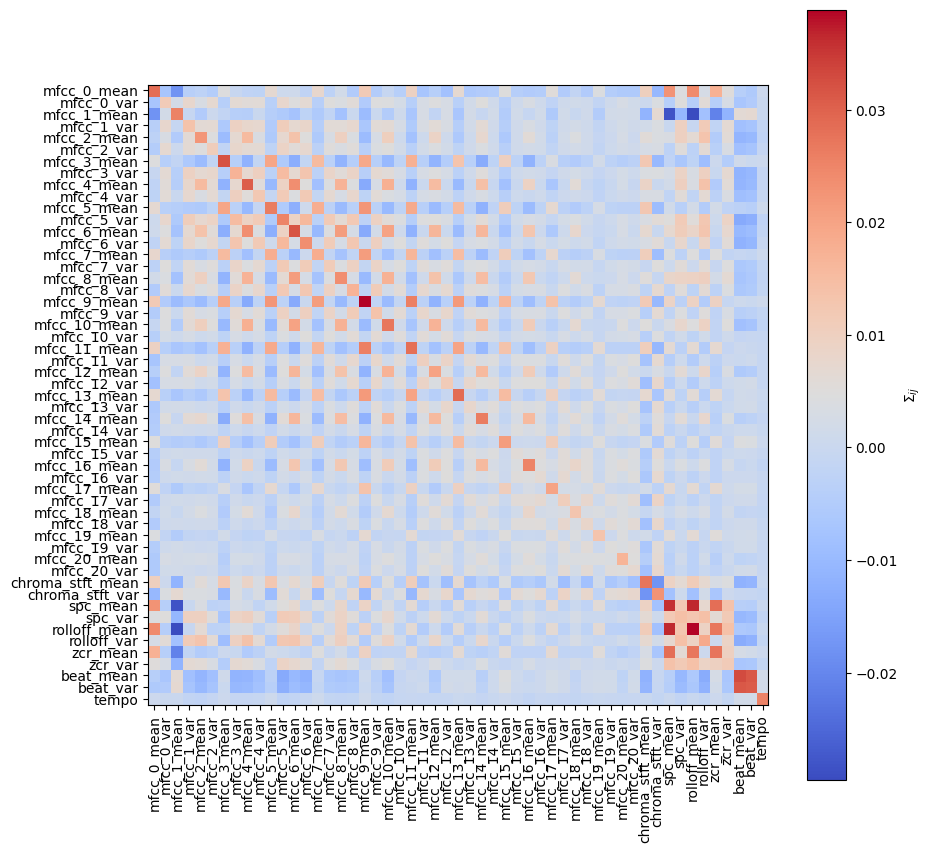

In [318]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(np.cov(Xscale.T), cmap=plt.cm.coolwarm)

_ = ax.set_xticks(np.arange(X.shape[1]), feat_names, rotation=90)
_ = ax.set_yticks(np.arange(X.shape[1]), feat_names)

cbar = fig.colorbar(im)
cbar.set_label('$\Sigma_{ij}$')

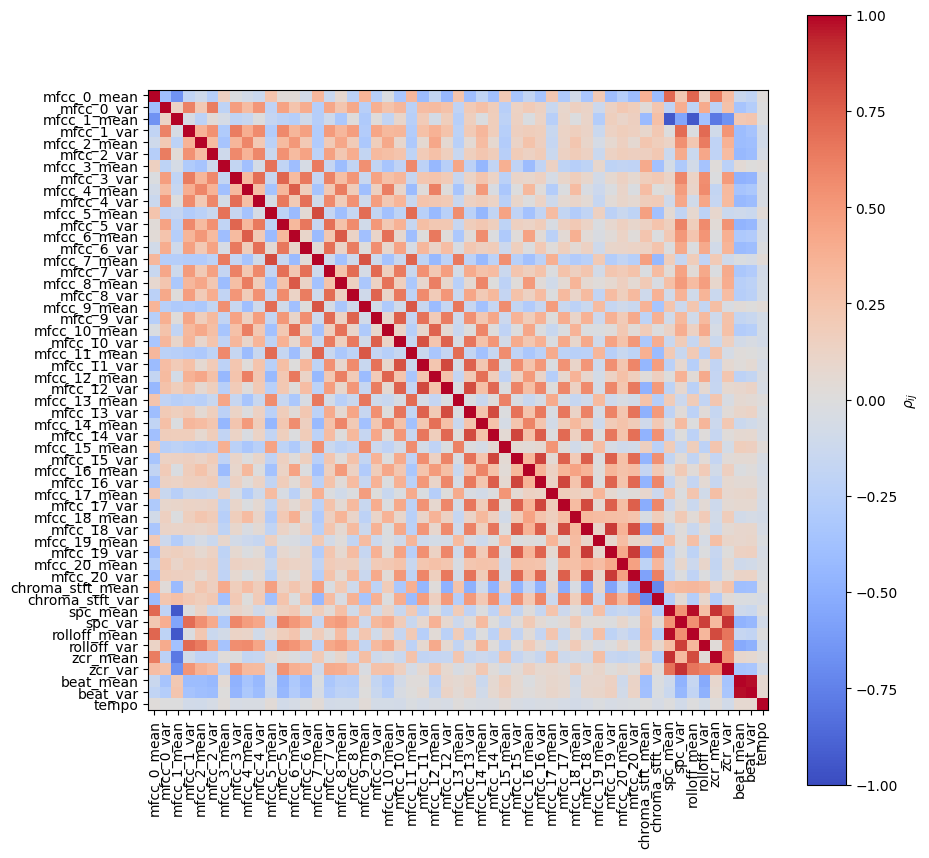

In [353]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(np.corrcoef(Xscale, rowvar=False), cmap=plt.cm.coolwarm, vmin=-1, vmax=1)

_ = ax.set_xticks(np.arange(X.shape[1]), feat_names, rotation=90)
_ = ax.set_yticks(np.arange(X.shape[1]), feat_names)

cbar = fig.colorbar(im)
cbar.set_label(r'$\rho_{ij}$')

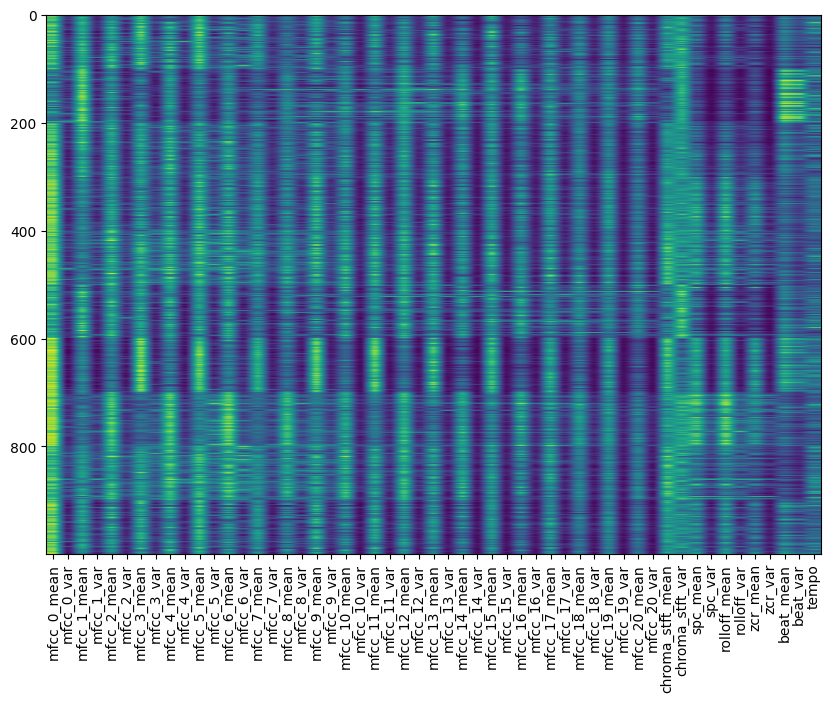

In [355]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.imshow(Xscale[y.argsort(), :], aspect='auto')
_ = ax.set_xticks(np.arange(X.shape[1]), feat_names, rotation=90)

In [347]:
ind_tr, ind_ts = [], []
for yu in np.unique(y):
    ind = np.where(y == yu)[0]
    np.random.shuffle(ind)
    ind_tr.append(ind[:int(0.8 * len(ind))])
    ind_ts.append(ind[int(0.8 * len(ind)):])
ind_tr = np.concatenate(ind_tr)
ind_ts = np.concatenate(ind_ts)

In [348]:
Xtr, ytr, Xts, yts = Xscale[ind_tr], y[ind_tr], Xscale[ind_ts], y[ind_ts]

In [349]:
D = ((Xtr[:, None, :] - Xts[None, :, :]) ** 2).sum(axis=-1)

In [350]:
acc = (1 * (ytr[D.argmin(axis=0)] == yts)).sum() / len(yts)

print(acc)

0.695


In [351]:
for yu in np.unique(ytr):
    ind = np.where(yts == yu)[0]
    acc = (1 * (ytr[D.argmin(axis=0)][ind] == yts[ind])).sum() / len(ind)
    
    print(f'Class: {int_to_class_name[yu]}, acc: {acc}')

Class: blues, acc: 0.8
Class: classical, acc: 0.95
Class: country, acc: 0.75
Class: disco, acc: 0.5
Class: hiphop, acc: 0.7
Class: jazz, acc: 0.85
Class: metal, acc: 0.8
Class: pop, acc: 0.7
Class: reggae, acc: 0.45
Class: rock, acc: 0.45


In [352]:
sigma = np.cov(Xscale.T)

In [327]:
D, V = np.linalg.eig(sigma)

In [328]:
W = V[:, :2]

In [329]:
Xproj = np.dot(Xscale, W)

In [330]:
Xproj

array([[0.13571733, 1.37375215],
       [0.85574464, 1.83305069],
       [0.69062535, 1.59996331],
       ...,
       [0.70139225, 2.12946529],
       [0.98999906, 1.2591327 ],
       [0.56603131, 1.0639767 ]])

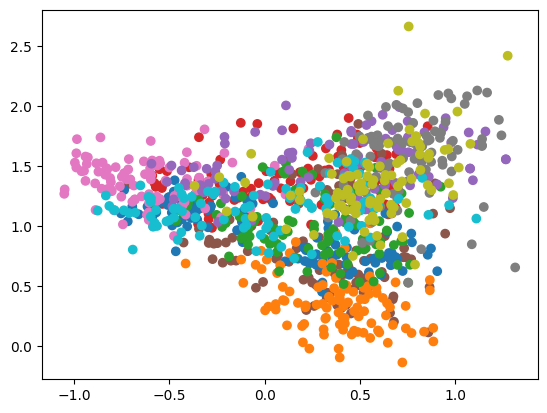

In [331]:
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, cmap='tab10')

In [332]:
from sklearn.svm import SVC

In [339]:
clf = SVC(kernel='linear', C=1)

In [340]:
clf.fit(Xtr, ytr)

SVC(C=1, kernel='linear')

In [341]:
(1 * (clf.predict(Xts) == yts)).sum() / len(yts)

0.705